In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

In [10]:
file='music_genre.csv'
data_raw = pd.read_csv(file)
data_raw.shape

(50005, 18)

Таблица содержит 50000 песен, для которых приведены различные признаки
Необходимо натренировать модель, которая по этим признакам определяет жанр музыки

In [11]:
data_raw.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [12]:
# удалим все строчки, в которых присутствуют пропущенные значения
# для длительности значение является пропущенным, если оно равно -1
data_raw = data_raw.dropna(axis = 0)
data_raw.drop(data_raw.loc[data_raw['duration_ms'] == -1.0].index, inplace=True)
# удалим признак obtained_date, он не несёт никакой полезной информации
# это дата добавления информации в базу
data_raw = data_raw.drop(columns=['obtained_date'])
# для столбца tempo пропущенным значением является ?
data_raw.drop(data_raw.loc[data_raw['tempo'] == '?'].index, inplace=True)
# instance_id также не несёт полезной информации, это просто идентификатор песни
data_raw.drop(columns='instance_id', inplace=True)
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40560 entries, 1 to 50004
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       40560 non-null  object 
 1   track_name        40560 non-null  object 
 2   popularity        40560 non-null  float64
 3   acousticness      40560 non-null  float64
 4   danceability      40560 non-null  float64
 5   duration_ms       40560 non-null  float64
 6   energy            40560 non-null  float64
 7   instrumentalness  40560 non-null  float64
 8   key               40560 non-null  object 
 9   liveness          40560 non-null  float64
 10  loudness          40560 non-null  float64
 11  mode              40560 non-null  object 
 12  speechiness       40560 non-null  float64
 13  tempo             40560 non-null  object 
 14  valence           40560 non-null  float64
 15  music_genre       40560 non-null  object 
dtypes: float64(10), object(6)
memory usage: 5.3+ 

C:\Users\akrug\AppData\Local\Temp\ipykernel_9396\75218715.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='music_genre', data=data_raw, palette = "Set2")


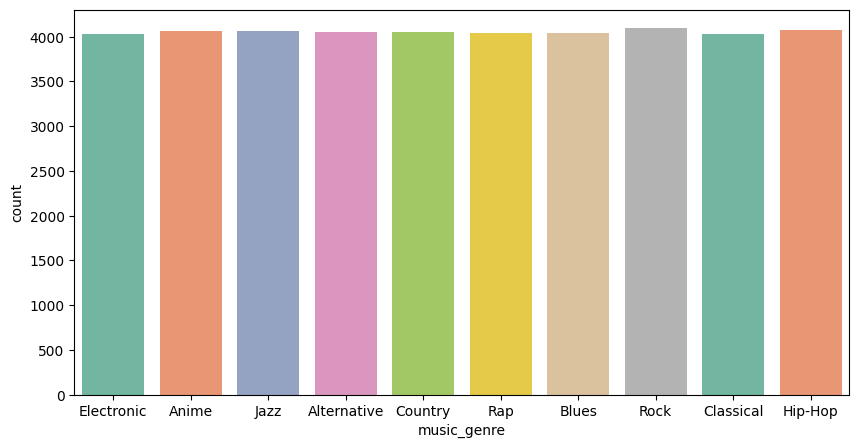

In [13]:
plt.figure(figsize=(10, 5))
sns.countplot(x='music_genre', data=data_raw, palette = "Set2")
pass

In [14]:
class_names=sorted(data_raw['music_genre'].unique().tolist())
M=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,M)) 
reverse_mapping=dict(zip(M,class_names))       
data_raw['music_genre']=data_raw['music_genre'].map(normal_mapping)
data_raw.head()

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
1,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,5
2,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.534,-4.617,Major,0.0345,127.994,0.333,5
3,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.157,-4.498,Major,0.2390,128.014,0.270,5
4,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.157,-6.266,Major,0.0413,145.036,0.323,5
6,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.106,-4.294,Major,0.3510,149.995,0.230,5


In [15]:
data_raw['tempo'] = data_raw['tempo'].astype('float64')
# превратим категориальный признак mode, в столбец из 0, 1
# 1 - Minor, 0 - Major
data_raw = pd.get_dummies(data_raw, columns = ['mode'], dtype=np.uint8, drop_first=True)
data_raw.describe()


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,music_genre,mode_Minor
count,40560.000000,40560.000000,40560.000000,4.056000e+04,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,44.276677,0.305974,0.558418,2.454895e+05,0.600330,0.181603,0.193820,-9.126369,0.093738,119.874523,0.456921,4.505843,0.359985
std,15.545617,0.341108,0.178652,1.101214e+05,0.264501,0.325710,0.161501,6.154679,0.101502,30.653215,0.246942,2.875219,0.480002
min,0.000000,0.000000,0.059600,1.550900e+04,0.000792,0.000000,0.009670,-47.046000,0.022300,34.347000,0.000000,0.000000,0.000000
25%,34.000000,0.020000,0.442000,1.904800e+05,0.433000,0.000000,0.097000,-10.843000,0.036100,94.893000,0.259000,2.000000,0.000000
50%,45.000000,0.144000,0.569000,2.275330e+05,0.644000,0.000157,0.126000,-7.277000,0.048900,119.755500,0.449000,5.000000,0.000000
75%,56.000000,0.550000,0.687000,2.757600e+05,0.817000,0.152000,0.244000,-5.174000,0.098800,140.344000,0.648000,7.000000,1.000000
max,99.000000,0.996000,0.986000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.276000,0.992000,9.000000,1.000000


Построим графики зависимости от некоторых признаков

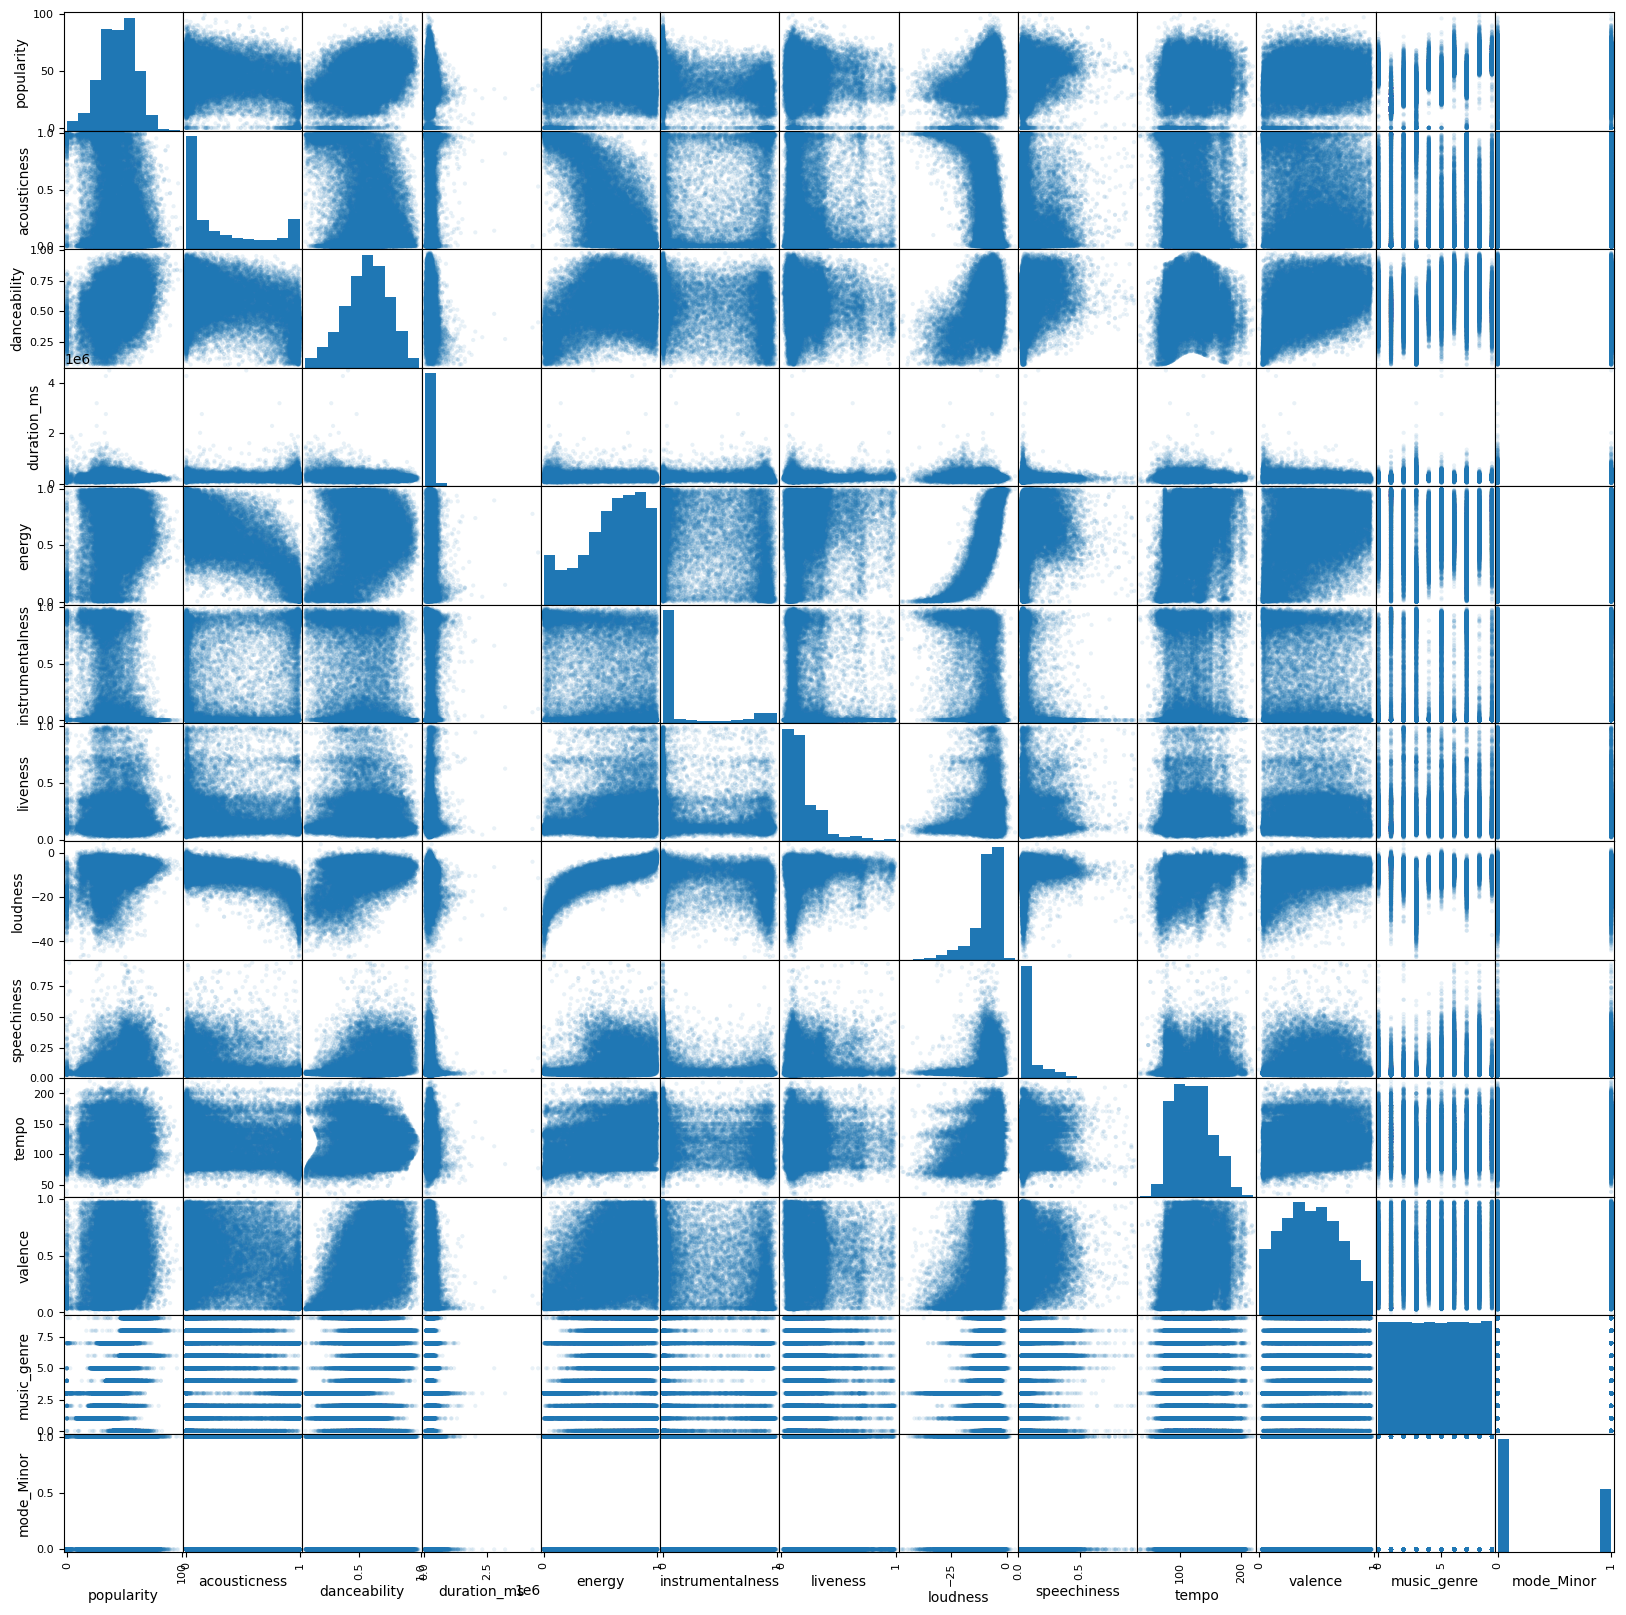

In [16]:
from pandas.plotting import scatter_matrix
scatter_matrix(data_raw, alpha = .1, figsize = (20, 20))
pass

Видно, что признак valence никак не классифицирует жанр музыки

Низкие значения признака loudness, практически однозначно определяют класс с номером 4

Низкие значения признака popularity выделяют подгруппу жанров с номерами 2, 4, 10, также есть примесь от 3, 5, 6 жанров

А высокие значения признака popularity выделяют 7 и 9 класс

Высокие параметры speechiness соотвестуют номерам 1, 3, 7, 8, 9

Значения duration, близкие к середине, подходят классу с номером 4

Классы с номерами 5, 7, 9 зачастую имеют признак instrumentalness близкий к 0

In [17]:
data_raw.drop(columns=['valence'], inplace=True)
data_raw.head()

,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,music_genre,mode_Minor
1,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,D,0.124,-7.043,0.0300,115.002,5,1
2,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,G#,0.534,-4.617,0.0345,127.994,5,0
3,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,C#,0.157,-4.498,0.2390,128.014,5,0
4,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,F#,0.157,-6.266,0.0413,145.036,5,0
6,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,B,0.106,-4.294,0.3510,149.995,5,0


In [18]:
cols=list(data_raw.columns)
cols.remove('artist_name')
cols.remove('track_name')
cols.remove('key')
corr_mat = data_raw[cols].corr()
corr_mat

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,music_genre,mode_Minor
popularity,1.000000,-0.289318,0.357883,-0.110858,0.216188,-0.363928,-0.041293,0.317655,0.223058,0.031902,0.503324,0.014969
acousticness,-0.289318,1.000000,-0.347304,0.085135,-0.790900,0.387188,-0.108336,-0.729482,-0.163502,-0.232860,-0.095511,-0.023590
danceability,0.357883,-0.347304,1.000000,-0.203663,0.263884,-0.297791,-0.050713,0.389374,0.277976,-0.016128,0.301505,0.049583
duration_ms,-0.110858,0.085135,-0.203663,1.000000,-0.094429,0.169260,0.028066,-0.138764,-0.110085,-0.046663,-0.034383,0.013321
energy,0.216188,-0.790900,0.263884,-0.094429,1.000000,-0.389594,0.184984,0.838143,0.158633,0.264170,0.032321,0.016444
instrumentalness,-0.363928,0.387188,-0.297791,0.169260,-0.389594,1.000000,-0.093584,-0.529675,-0.198822,-0.127444,-0.109853,0.063678
liveness,-0.041293,-0.108336,-0.050713,0.028066,0.184984,-0.093584,1.000000,0.123366,0.115905,0.038684,-0.024595,-0.016248
loudness,0.317655,-0.729482,0.389374,-0.138764,0.838143,-0.529675,0.123366,1.000000,0.165343,0.240462,0.100852,0.007903
speechiness,0.223058,-0.163502,0.277976,-0.110085,0.158633,-0.198822,0.115905,0.165343,1.000000,0.062357,0.189308,0.076154
tempo,0.031902,-0.232860,-0.016128,-0.046663,0.264170,-0.127444,0.038684,0.240462,0.062357,1.000000,-0.022674,-0.022748


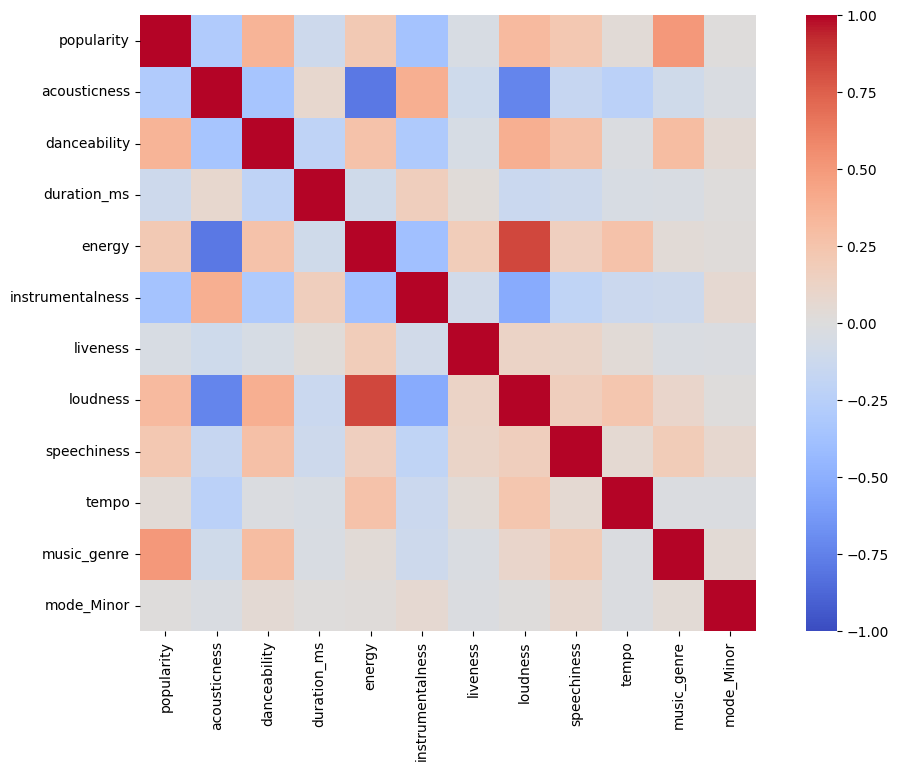

In [19]:
plt.figure(figsize = (13, 8))
sns.heatmap(corr_mat, square=True, vmin=-1, vmax=1, cmap='coolwarm')
pass

Видно, что наиболее выраженная зависимость наблюдается между признаками energy и loudness.
Один из них можно удалить.

In [20]:
from sklearn.model_selection import train_test_split
# для начала удалим текстовые признаки
# позже можно будет попробовать проинтерпретировать признак key как категориальный и заменить его на столбцы из 0 и 1
X = data_raw.drop(columns=['music_genre', 'key', 'artist_name', 'track_name'])
y = data_raw['music_genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 49)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(32448, 8112)

In [21]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=12)
knn.fit(X_train, y_train)

err_test = 1 - knn.score(X_test, y_test)
err_test

0.847879684418146

In [22]:
from  sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_names))
print(normal_mapping)

              precision    recall  f1-score   support

 Alternative       0.11      0.21      0.14       755
       Anime       0.18      0.23      0.20       774
       Blues       0.13      0.14      0.14       818
   Classical       0.28      0.27      0.27       852
     Country       0.14      0.18      0.16       811
  Electronic       0.15      0.12      0.14       859
     Hip-Hop       0.14      0.11      0.13       838
        Jazz       0.16      0.11      0.13       764
         Rap       0.10      0.07      0.08       802
        Rock       0.13      0.08      0.10       839

    accuracy                           0.15      8112
   macro avg       0.15      0.15      0.15      8112
weighted avg       0.15      0.15      0.15      8112

{'Alternative': 0, 'Anime': 1, 'Blues': 2, 'Classical': 3, 'Country': 4, 'Electronic': 5, 'Hip-Hop': 6, 'Jazz': 7, 'Rap': 8, 'Rock': 9}


Точность получилась маленькой. Попробуем перебрать множества используемых признаков значения.

In [23]:
cols=list(data_raw.columns)
cols.remove('artist_name')
cols.remove('track_name')
cols.remove('key')
cols.remove('music_genre')

In [389]:
from itertools import combinations
from sklearn.metrics import accuracy_score

best_features = []
best_score = 0.0
best_cnt_nb = 0
for features_num in range(8, 12, 1):
    for cnt_neighbors in range(5, 40, 5):
        for combination in combinations(cols, features_num):
            X = data_raw[list(combination)]
            y = data_raw['music_genre']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 49)

            knn = KNeighborsClassifier(n_neighbors=cnt_neighbors)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            cur_score = accuracy_score(y_test, y_pred)
            if cur_score > best_score:
                best_features = combination
                best_score = cur_score
                best_cnt_nb = cnt_neighbors

print('Best score: ', best_score)
print('Best features: ', best_features)
print('Best count neighbours: ', best_cnt_nb)

Best score:  0.47645463510848124
Best features:  ('popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'mode_Minor')
Best count neighbours:  35


Возьмём полученный список параметров и выполним по нему полный перебор

In [24]:
features = ['popularity', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'mode_Minor']
features

['popularity',
 'acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'liveness',
 'speechiness',
 'mode_Minor']

In [25]:
from itertools import combinations
from sklearn.metrics import accuracy_score

best_features = []
best_score = 0.0
best_cnt_nb = 0
for features_num in range(1, len(features)):
    for cnt_neighbors in range(5, 40, 5):
        for combination in combinations(features, features_num):
            X = data_raw[list(combination)]
            y = data_raw['music_genre']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 49)

            knn = KNeighborsClassifier(n_neighbors=cnt_neighbors)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            cur_score = accuracy_score(y_test, y_pred)
            if cur_score > best_score:
                best_features = combination
                best_score = cur_score
                best_cnt_nb = cnt_neighbors

In [26]:
print('Best score: ', best_score)
print('Best features: ', best_features)
print('Best count neighbours: ', best_cnt_nb)

Best score:  0.4843441814595661
Best features:  ('popularity', 'acousticness', 'danceability', 'instrumentalness', 'speechiness')
Best count neighbours:  20


Итоговая точность - 48%
Можно попробовать добиться большей точности, если учитывать исполнителя песни, так как зачастую один и тот же автор зачастую играет музыку в одном жанре